In [1]:
!git clone https://github.com/daniarnaizg/text-detector-ocr.git

Cloning into 'text-detector-ocr'...
remote: Counting objects: 87, done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 87 (delta 5), reused 15 (delta 3), pack-reused 68
Unpacking objects: 100% (87/87), done.
Checking out files: 100% (22/22), done.


In [2]:
!ls

datalab  text-detector-ocr


In [2]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import Flatten, Lambda, BatchNormalization
from keras.models import Sequential

# initialize the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model_path = 'text-detector-ocr/Models/text-notext.h5'
model.load_weights(model_path)

Using TensorFlow backend.


In [0]:
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array

def get_prediction(image):
  orig = image.copy()

  # pre-process the image for classification
  image = cv2.resize(image, (28, 28))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  
  (notext, text) = model.predict(image)[0]
  pred = True if text > notext else False

  return pred

In [0]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [0]:
from matplotlib import pyplot as plt
import cv2
import os
import time

def slide_predict(file_name, size):

  image = cv2.imread(file_name)
  image = cv2.resize(image, (1280, 720))
  (W, H) = (size, size)
  
  orig = image.copy()
  
  points = []
  
  for (x, y, window) in sliding_window(orig, stepSize=32, windowSize=(W, H)):
    if window.shape[0] != H or window.shape[1] != W:
  		continue
      
    cropped = orig[y:y+H, x:x+W]
    text = get_prediction(cropped)
      
    if text:
      cv2.rectangle(image, (x, y), (x + W, y + H), (0, 255, 0), 2)
      points.append([x, y])
        
  plt.imshow(image)
  plt.axis('off')
  plt.show()      
  
  return points

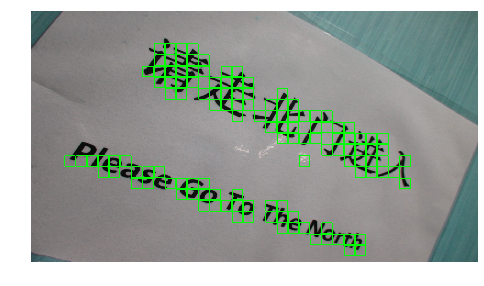

In [76]:
p = slide_predict('text-detector-ocr/Resources/test_images/4.jpg', 30)

In [0]:
def get_min_distance(point, cluster):
  min_dist = 999
  for c in cluster:
    new_dist = abs(point[0] - c[0]) + abs(point[1] - c[1])
    if new_dist < min_dist:
      min_dist = new_dist
  return min_dist
    

In [0]:
def get_clusters(points, t):
  
  clusters = {}
  added_points = []
  
  for point in points:
#     clusters[str(len(clusters))] = [point]
    
    if len(clusters) is 0:
      clusters[str(len(clusters) + 1)] = [point]
    else:
      for key in clusters.keys():
        added = False
        dist = get_min_distance(point, clusters.get(key))
        if dist <= t and point not in added_points:
          clusters[key].append(point)
          added_points.append(point)
          added = True
        if added is False and point not in added_points:
          clusters[str(len(clusters) + 1)] = [point]
  
  return clusters

In [0]:
import numpy as np

def get_min_rect(cluster, size):
  
  minx, miny = 999, 999
  maxx, maxy = 0, 0
  
  for x, y in cluster:
    
    # Set min coords
    if x < minx:
      minx = x
    if y < miny:
      miny = y
      
    # Set max coords
    if x > maxx:
      maxx = x
    elif y > maxy:
      maxy = y
      
  w = np.abs(maxx - minx) + size
  h = np.abs(maxy - miny) + size
    
  return [minx, miny, minx+w, miny+h]
  
  

In [0]:
def draw_rect(image, clusters, size=30):
  image = cv2.imread(image)
  image = cv2.resize(image, (1280, 720))
  clone = image.copy()
  
  count = 0
  for cluster in clusters.values():
    
    if len(cluster) < 2:
#       print("Unique element cluster. Ignoring...")
      continue
      
    coord = get_min_rect(cluster, size)
    cv2.rectangle(clone, (coord[0], coord[1]), (coord[2], coord[3]), (0, 255, 0), 2)
    count = count + 1
  
  print(str(count) + ' clusters')
  plt.imshow(clone)
  plt.axis('off')
  plt.show() 
    

In [10]:
!ls text-detector-ocr/Resources/test_images/

1.jpg  2.jpg  3.jpg  4.jpg  5.jpg  6.jpg  7.jpg  8.jpg


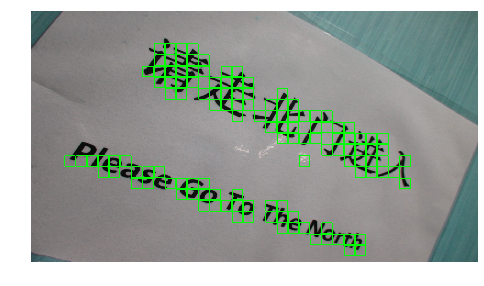

6 clusters


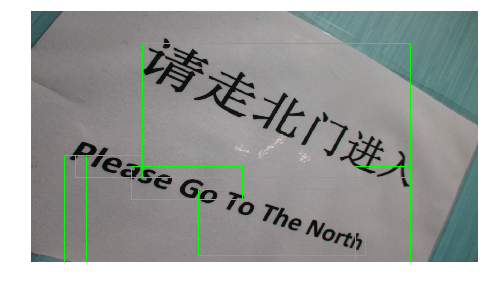

In [85]:
image = 'text-detector-ocr/Resources/test_images/4.jpg'
size = 30
threshold = size*3.5
points = slide_predict(image, size)
clusters = get_clusters(points, threshold)
draw_rect(image, clusters)